# Model Testing

Compiling the main code for testing different models here:

In [4]:
# fastchem and documentation available at: https://github.com/exoclime/FastChem
# petitRADTRANS and documentation available at: https://petitradtrans.readthedocs.io/en/latest/ 

import numpy as np
import time
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
import pylab as plt
import scipy
from scipy import ndimage
import csv
import pyfastchem
#Input path to the file fastchem/python/save_output.py, replacing / with . where applicable
from fastchem.python.save_output import saveChemistryOutput, saveMonitorOutput, saveChemistryOutputPandas, saveMonitorOutputPandas
import os
from astropy import constants as const
from pathlib import Path
import collections
from tkinter import *

# ----------------------------------------------------------------------------------------------------------- #
####### PARAMETERS -- USER INPUT -- VALUES BELOW ARE FOR AU Mic b
# ----------------------------------------------------------------------------------------------------------- #

Rp        = 0.363*nc.r_jup_mean     # Planet radius [cm] 
Rs        = 0.75*nc.r_sun           # Stellar radius [cm] (planet and stellar radius from: https://arxiv.org/abs/2006.13248) 
Mass      = 11.7*nc.m_earth         # Planet mass [g] (mass estimate from: https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.3060Z/abstract)
gravity   = (nc.G*Mass)/(Rp**2)     # Planet surface gravity [cgs]
P0        = 0.01                    # Reference pressure [bar]
#fact     = 0.01                   # Multiplicative factor to extend the wavelength ranges for petitRADTRANS
                                   # e.g., fact = 0.01 means that the wavelength range is 1% larger than the  min/max wavelengths in the input wave file
    
#Guillot Temperature profile parameters:
kappa_IR = 0.03                    # Atmospheric opacity in IR wavelengths (cross-section per unit mass)
gamma = 0.032                        # Ratio between optical and IR opacity 
T_int = 200.                       # Planetary internal temperature [K] -- Guillot model
T_equ = 593.                      # Atmospheric Equilibrium Temperature (External) [K] -- Guillot model#

# -------------------------------------------------------------------------------------------------------------#
###### MODEL -- USER INPUT -- Input values here for the metallicities, C/O ratios and species you want to include
#                             in atmosphere abundance calculations. Code will iterate over each C/O value for each 
#                             metallicity.
# -------------------------------------------------------------------------------------------------------------#

#Input atmospheric metallicities of planet to test, in units of solar metallicity:
metallicities = [1, 100]

#Input atmospheric C/O ratios to test:
C_O_ratios = [0.5, 1] 

#The 4 lists below will each need to be updated if the list of species is changed, and the respective order 
# needs to be maintained with each species consistently in same index in each list.

# Input species you want to be included in atmospheric abundance calculations, in modified Hill notation
# (as seen below) - note that HCN is C1H1N1_1
# Note these are not necessarily the species you will be generating spectra for in pRT.
plot_species = ['H2O1', 'C1O2', 'C1O1', 'C1H4', 'H3N1', 'H2', 'He', 'N2']
# Labels for respective species in list above, for plots. 
plot_species_lables = ['H2O', 'CO2', 'CO', 'CH4', 'NH3', 'H2', 'He', 'N2']

# Input species names as given in pRT - to allow pRT to pick up the data from the fastchem output. This list
# will also be used as input into pRT function later.
pRT_names = ['H2O_main_iso', 'CO2_main_iso', 'CO_all_iso', 'CH4_main_iso', 'NH3_main_iso','H2', 'He', 'N2']

#List of MMW of each of the species, in units of proton mass (g/mol): IF ADDING MORE SPECIES, ADD THEIR MMW
# MMW values can be found here: https://pubchem.ncbi.nlm.nih.gov/
molecule_mmw = [18.01528, 44.01, 28.01, 16.04, 17.031, 2.016, 4.0026, 28.014]

 
#Note there are some more inputs later on defined in functions so check before running

### MAIN CODE ###

pressure                    = np.logspace(-10, 2, 130)           # Pressure grid [bar] 
temperature = nc.guillot_global(pressure, kappa_IR, gamma, gravity, T_int, T_equ)


# Function generating the P,T profile:
# By default, T_equ = 593K (well constrained) and T_int = 200K (less well constrained), so can vary if necessary.
# If testing different profiles; conditions can be a single list of for one model, or a list of lists for
# with multiple conditions to model - format: conditions = [[gamma1, kappa_IR1],[gamma1, kappa_IR2],...] 
# If using within generate_spectra function, the gamma, kappa_IR input parameters in that function will be used as 
# the default conditions here, as it can only take one model.

def PT_profile(conditions=[[gamma, kappa_IR]], T_int=200, T_equ=593):
    for cond in conditions:
        gamma = cond[0]
        kappa_IR = cond[1]
        plt.plot(temperature, pressure, label= r'$\gamma$ =' + str(gamma) + ", " r'$\kappa_{IR}$ =' + str(kappa_IR))
        plt.yscale('log')
        plt.xlim([400,1600])
        plt.ylim([1e2, 1e-6])
        plt.tick_params(labelright=True, right=True)
        plt.xlabel('T (K)')
        plt.ylabel('P (bar)')
    plt.legend()    
    plt.show()
    plt.clf()
    

# Normalisation function: so you can define the size you want:
def normalisation(input_data, size):
    maximum = scipy.ndimage.maximum_filter(input_data, size)
    normalised_max = input_data/maximum
    return normalised_max
    
    
# Fastchem function: calculates the relative molecular abundances based on elemental abundances and the model.
# Produces plot of the mixing ratio and saves the figure and data.
def fastchem(metallicity, ratio):
    #PATH TO DESIRED OUTPUT FOLDER - all plots and data will be saved here, for each model
    output_dir = 'Output/'+str(metallicity)+'x_metallicity_'+str(ratio)+'_CO_ratio/'
    
    #INPUT YOUR PATH TO fastchem/input/elemental_abundances_solar.dat and fastchem/input/logK.dat
    fastchem = pyfastchem.FastChem('/Users/pearceo/Documents/fastchem/input/element_abundances_solar.dat', 
                                   '/Users/pearceo/Documents/fastchem/input/logK.dat', 1)

    solar_abundances = np.array(fastchem.getElementAbundances())
    index_C = fastchem.getSpeciesIndex('C')


    #Copy of the solar abundances from FastChem, for changing elemental abundances based on metallicity or C/O.
    element_abundances = np.copy(solar_abundances)
    #Adapting elemental abundances for the metallicity and C/O ratio specified.
    for j in range(0, fastchem.getElementNumber()):
        if fastchem.getSpeciesSymbol(j) != 'H' and fastchem.getSpeciesSymbol(j) != 'He' and fastchem.getSpeciesSymbol(j) != 'O':
            element_abundances[j] *= metallicity
        elif fastchem.getSpeciesSymbol(j) == 'O':
            element_abundances[j] = solar_abundances[index_C] * metallicity/ratio
    fastchem.setElementAbundances(element_abundances)    


    input_data = pyfastchem.FastChemInput()
    output_data = pyfastchem.FastChemOutput()

    input_data.temperature = temperature
    input_data.pressure = pressure
    #run FastChem on the entire p-T structure
    fastchem_flag = fastchem.calcDensities(input_data, output_data)
    print("FastChem reports:", pyfastchem.FASTCHEM_MSG[fastchem_flag])


    #convert the output into a numpy array
    number_densities = np.array(output_data.number_densities)

    #total gas particle number density from the ideal gas law 
    #used later to convert the number densities to mixing ratios
    gas_number_density = pressure*1e6 / (const.k_B.cgs * temperature)


    #check if output directory exists, create it if it doesn't
    os.makedirs(output_dir, exist_ok=True)


    ## Save the monitor output to a file
    ## This saves debug output in a file (see fastchem manual if issues), uncomment to investigate issues.
    ## Checks if a file for this model already exists, if not it creates one.
    #file = Path(output_dir + '/monitor'+str(metallicity)+'xsolar_'+str(ratio)+'_C_O.dat')
    #file.touch(exist_ok=True)
    #saveMonitorOutput(file, 
    #                  temperature, pressure, 
    #                  output_data.element_conserved,
    #                  output_data.fastchem_flag,
    #                  output_data.nb_chemistry_iterations,
    #                  output_data.total_element_density,
    #                  output_data.mean_molecular_weight,
    #                  fastchem)

    ## This would save the output of all species
    #saveChemistryOutput(output_dir + '/chemistry.dat', 
    #                    temperature, pressure, 
    #                    output_data.total_element_density, 
    #                    output_data.mean_molecular_weight, 
    #                    output_data.number_densities, 
    #                    fastchem)

    # This saves only selected species (the species we plot)
    # Checks if a file for this model already exists, if not it creates one.
    file = Path(output_dir + '/fastchem.dat')
    file.touch(exist_ok=True)
    saveChemistryOutput(file, 
                        temperature, pressure, 
                        output_data.total_element_density, 
                        output_data.mean_molecular_weight, 
                        output_data.number_densities, 
                        fastchem,
                        plot_species)


#save the monitor output to a file
#here, the data is saved as a pandas DataFrame inside a pickle file
# saveMonitorOutputPandas(output_dir + '/monitor.pkl', 
#                   temperature, pressure, 
#                   output_data.element_conserved,
#                   output_data.fastchem_flag,
#                   output_data.nb_chemistry_iterations,
#                   output_data.total_element_density,
#                   output_data.mean_molecular_weight,
#                   fastchem)

# #this would save the output of all species
# #here, the data is saved as a pandas DataFrame inside a pickle file
# saveChemistryOutputPandas(output_dir + '/chemistry.pkl',
#                     temperature, pressure,
#                     output_data.total_element_density,
#                     output_data.mean_molecular_weight,
#                     output_data.number_densities,
#                     fastchem)



    #check the species we want to plot and get their indices from FastChem
    plot_species_indices = []
    plot_species_symbols = []

    for i, species in enumerate(plot_species):
        index = fastchem.getSpeciesIndex(species)

        if index != pyfastchem.FASTCHEM_UNKNOWN_SPECIES:
            plot_species_indices.append(index)
            plot_species_symbols.append(plot_species_lables[i])
        else:
            print("Species", species, "to plot not found in FastChem")


    #and plot...
    plt.figure(figsize=[20,12])
    for i in range(0, len(plot_species_symbols)):  
        plt.plot(number_densities[:, plot_species_indices[i]]/gas_number_density, pressure)


    plt.xscale('log')
    plt.yscale('log')
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])

    plt.xlabel("Mixing ratios")
    plt.ylabel("Pressure (bar)")
    plt.title('Mixing ratios at '+ str(metallicity) + 'x solar metallicity, '+str(ratio)+' C/O ratio')
    plt.legend(plot_species_symbols)
    #Saving figure to a file, creating one if it does not exist
    file = Path(output_dir + '/fastchem_fig.pdf')
    #print(file)
    file.touch(exist_ok=True)
    plt.savefig(file)
    plt.show()

    # Converting relative mixing ratios to mass fractions, as pRT input abundances need to be in mass fraction:
    abundances = collections.defaultdict(list)
    number_fractions = collections.defaultdict(list)

    #list of MMW weight, as they vary (albeit insignificantly) between p/T in each model as abundances change.
    MMW = []

    # Calculating mass fractions from relative abundance output of fastchem and storing for pRT input
    values = []
    with open(output_dir + '/fastchem.dat') as fastchem_results:
        lines = fastchem_results.readlines()
        for row in lines:
            values.append(row.split())
        for j in range(0,len(values)-1):
            MMW.append(float(values[j+1][4]))
            for species in plot_species:
            #Accounting for syntax of fastchem output file, giving index of the column of each species:
                abundance_index = values[0].index(species) - 5
                pRT_index = plot_species.index(species)
                molecule=pRT_names[pRT_index]
                #j+1 to skip first line here, but use same index from 0 later
                number_fractions[molecule].append(values[j+1][abundance_index])
                mass_frac = float(number_fractions[molecule][j])*molecule_mmw[pRT_index]/float(MMW[j])
                abundances[molecule].append(mass_frac) 
        fastchem_results.close()

    #Converting the lists to arrays for input in pRT
    for name in abundances:
        abundances[name]=np.array(abundances[name])
    MMW = np.array(MMW)
    return MMW, abundances, output_dir


# This function takes the output from fastchem and inputs into pRT, calculating the atmosphere and generating the plots.
# INPUTS:
# LS - list of species to calculate atmospheric spectrum for
# min/max_wavelength: wavelength range to calculate atmosphere for: larger ranges significantly increase computation time
# temp_profile: can use either an isothermal or Guillot temperature profile
# gamma: Ratio between optical and IR opacity 
# kappa_IR: Atmospheric opacity in IR wavelengths (cross-section per unit mass)
# T_int: Planetary internal temperature [K]
# normalisation_size: size paraemeter used for input into normalisation function (scipy.ndimage.maximum_filter)

def generate_spectra(LS, min_wavelength, max_wavelength, temp_profile='Guillot', gamma=gamma,
                     kappa_IR=kappa_IR, T_int=T_int, normalisation_size=1000):
    
#    if temp_profile=='Guillot':
    #temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
        
# If we want to do isothermal P,T profile instead:
#    elif temp_profile=='Isothermal':
#        temperature  = T_equ * np.ones_like(pressures)


    # Calling PT_profile function to plot the profile:
    PT_profile(T_int=T_int)
        
#Iterate over each C/O ratio for each value of metallicity, to test all models. 
    for metallicity in metallicities:
        for ratio in C_O_ratios:
             
            

            # Calling fastchem function to calculate abundances
            MMW, abundances, output_dir = fastchem(metallicity, ratio)

            #Calculating contribution of each species for contribution plot:
            # NOTE - This plot will significantly increase computation time - if undesired just calculate
            # overall spectrum only.

            if len(LS) > 1:
                plt.figure(figsize=[20,12])
                for species in LS:        
                    atmosphere = Radtrans(line_species = [species], \
                              rayleigh_species = ['H2', 'He', 'N2'], \
                              continuum_opacities = ['H2-H2', 'H2-He', 'N2-N2'], \
                              wlen_bords_micron = [min_wavelength/1000.,max_wavelength/1000.], \
                              mode = 'lbl')

                    atmosphere.setup_opa_structure(pressure)
                    atmosphere.calc_transm(temperature,abundances,gravity,MMW,R_pl=Rp,P0_bar=P0)
                    atmosphere.calc_flux(temperature, abundances, gravity, MMW)

                    Rp_l = atmosphere.transm_rad     # Radius as function of wavelength
                    Wm   = nc.c/atmosphere.freq/1e-7 # Wavelengths [nm]
                    flux_variation = 1-((Rp_l**(2))/Rs**(2))    # Calculating the variation of flux

                    #Normalisation - calling function
                    normalised_max = normalisation(flux_variation, normalisation_size)

                    #Plotting contribution of each atmospheric species to the overall spectrum
                    # 'alpha' defines how opaque the lines are, put at 0.5 in an attempt to make it easier to see all species,
                    # not just the dominant ones.
                    plt.plot(Wm, normalised_max, label=species, alpha=0.5)

            #Calculating overall spectrum:

                atmosphere = Radtrans(line_species = LS, \
                              rayleigh_species = ['H2', 'He', 'N2'], \
                              continuum_opacities = ['H2-H2', 'H2-He', 'N2-N2'], \
                              wlen_bords_micron = [min_wavelength/1000.,max_wavelength/1000.], \
                              mode = 'lbl')

                atmosphere.setup_opa_structure(pressure)
                atmosphere.calc_transm(temperature,abundances,gravity,MMW,R_pl=Rp,P0_bar=P0)
                atmosphere.calc_flux(temperature, abundances, gravity, MMW)

                Rp_l = atmosphere.transm_rad     # Radius as function of wavelength
                Wm   = nc.c/atmosphere.freq/1e-7 #nm
                flux_variation = 1-((Rp_l**(2))/Rs**(2))    #Calculate the variation of flux

                #Normalisation
                normalised_max = normalisation(flux_variation, normalisation_size)

                # Along with contributions, this plots the overall spectrum so we can see which species are dominant. 
                plt.plot(Wm,normalised_max, label='Spectrum', alpha=0.5)
                plt.xlabel('Wavelength (nm)')
                plt.ylabel(r'Normalised Radius')
                plt.title('Normalised Transmission Spectrum also showing contribution from inidividual species at '+ str(metallicity) + 'x solar metallicity, '+str(ratio)+' C/O ratio')
                plt.legend()
                #Saving contribution spectrum, remove if unnecessary:
                file = Path(output_dir + '/Contribution_Spectrum_'+str(int(min_wavelength))+'_'+str(int(max_wavelength))+'.pdf')
                file.touch(exist_ok=True)
                plt.savefig(file)
                plt.show()
                plt.clf()
                
            # If only calculating species for one atmosphere, no need to plot contribution spectrum    

            if len(LS) == 1:
                atmosphere = Radtrans(line_species = LS, \
                              rayleigh_species = ['H2', 'He', 'N2'], \
                              continuum_opacities = ['H2-H2', 'H2-He', 'N2-N2'], \
                              wlen_bords_micron = [min_wavelength/1000.,max_wavelength/1000.], \
                              mode = 'lbl')

                atmosphere.setup_opa_structure(pressure)
                atmosphere.calc_transm(temperature,abundances,gravity,MMW,R_pl=Rp,P0_bar=P0)
                atmosphere.calc_flux(temperature, abundances, gravity, MMW)

                Rp_l = atmosphere.transm_rad     # Radius as function of wavelength
                Wm   = nc.c/atmosphere.freq/1e-7 #nm
                flux_variation = 1-((Rp_l**(2))/Rs**(2))    #Calculate the variation of flux

                #Normalisation
                normalised_max = normalisation(flux_variation, normalisation_size)

            # Saving the pRT data to an output file, a different file for each of the wavelength bounds
            # so that when calculating spectrum in chunks all of the data is saved
            file = Path(output_dir + '/pRT_data_'+str(int(min_wavelength))+'_'+str(int(max_wavelength))+'.dat')
            file.touch(exist_ok=True)
            with open(file, 'w') as pRT_output:
                pRT_output.write('Wavelength[nm] Flux_variation\n')
                for i in range(len(Wm)):
                    pRT_output.writelines(str(Wm[i]) + ' ' + str(flux_variation[i]) + '\n')
                pRT_output.close()
                
                   
            
            
            # Various plots, commented out but can plot if desired:

            # Plotting transit radius
            #print("Plot of Transit radius:")
            #plt.figure(figsize=[20,12])
            #plt.plot(Wm, atmosphere.transm_rad/nc.r_jup_mean)
            #plt.xscale('log')
            #plt.xlabel('Wavelength (nm)')
            #plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
            #plt.show()
            #plt.clf()    


            # Plotting transmission sprectrum in terms of raw flux
            #print("Transmission spectrum (Raw Flux):")
            #plt.figure(figsize=[20,12])
            #plt.plot(Wm, atmosphere.flux/1e-6)
            #plt.xscale('log')
            #plt.xlim([1.6e3,1.61e3])
            #plt.xlabel('Wavelength (nm)')
            #plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
            #plt.show()
            #plt.clf()


            # Gathering the min and max wavelength for each order in orders_spirou.dat file, 
            # for plotting on normalised spectrum.
            spirou_min = []
            spirou_max = []
            spirou = open("orders_spirou.dat", "r")
            spirou.readline()
            for line in spirou:
                values = line.split()
                spirou_min.append(values[2])
                spirou_max.append(values[3])

            # Ensuring that for each plot only the orders within the specified wavelength range are gathered.
            # NOTE -- The orders do overlap, so the max and min adjacent to each other don't necessarily define an order,
            #the orders typically cover ~50nm.

            wavelength_min = np.amin(Wm)
            wavelength_max = np.amax(Wm)
            orders_min = []
            orders_max = []

            for value in spirou_min:
                if float(value) > wavelength_min and float(value) < wavelength_max:
                    orders_min.append(float(value))
            for value in spirou_max:
                if float(value) > wavelength_min and float(value) < wavelength_max:
                    orders_max.append(float(value))

            # Plot of the unnormalised transmission spectrum (uncomment if desired)
            #print("Unnormalised Transmission Spectrum")    
            #plt.figure(figsize=[20,12])    
            #plt.plot(Wm, flux_variation, label='Spectrum')
            #plt.vlines(orders_min, ymin= np.amin(flux_variation), ymax=np.amax(flux_variation), colors='red', linestyles='dashed', label='Minimum of order')
            #plt.vlines(orders_max, ymin= np.amin(flux_variation), ymax=np.amax(flux_variation), colors='green', linestyles='dashed', label='Maximum of order')
            #plt.xscale('log')
            #plt.xlim([1.5e3, 1.7e3])
            #plt.xlabel('Wavelength (nm)')
            #plt.ylabel(r'Unnormalised Radius')
            #plt.legend()
            #plt.title('Unnormalised Transmission Spectrum showing maximum and minimum of diffraction grating orders')
            #plt.show()
            #plt.clf()

            # Plot of the normalised transmission spectrum.
            print("Normalised Transmission Spectrum")
            plt.figure(figsize=[20,12])
            plt.plot(Wm, normalised_max, label='Spectrum')
            plt.vlines(orders_min, ymin= np.amin(normalised_max), ymax=np.amax(normalised_max), colors='red', linestyles='dashed', label='Minimum of order')
            plt.vlines(orders_max, ymin= np.amin(normalised_max), ymax=np.amax(normalised_max), colors='green', linestyles='dashed', label='Maximum of order')
            #plt.xscale('log')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel(r'Normalised Radius')
            plt.title('Full Normalised Transmission Spectrum showing diffraction grating orders, at '+ str(metallicity) + 'x solar metallicity, '+str(ratio)+' C/O ratio')
            plt.legend()
            #Saving spectrum, remove if unnecessary:
            file = Path(output_dir + '/Full_Spectrum_'+str(int(min_wavelength))+'_'+str(int(max_wavelength))+'.pdf')
            file.touch(exist_ok=True)
            plt.savefig(file)
            plt.show()
            #plt.clf()


      
        
         
 

        

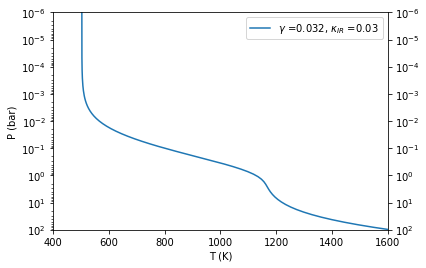

FastChem reports: convergence ok


<Figure size 432x288 with 0 Axes>

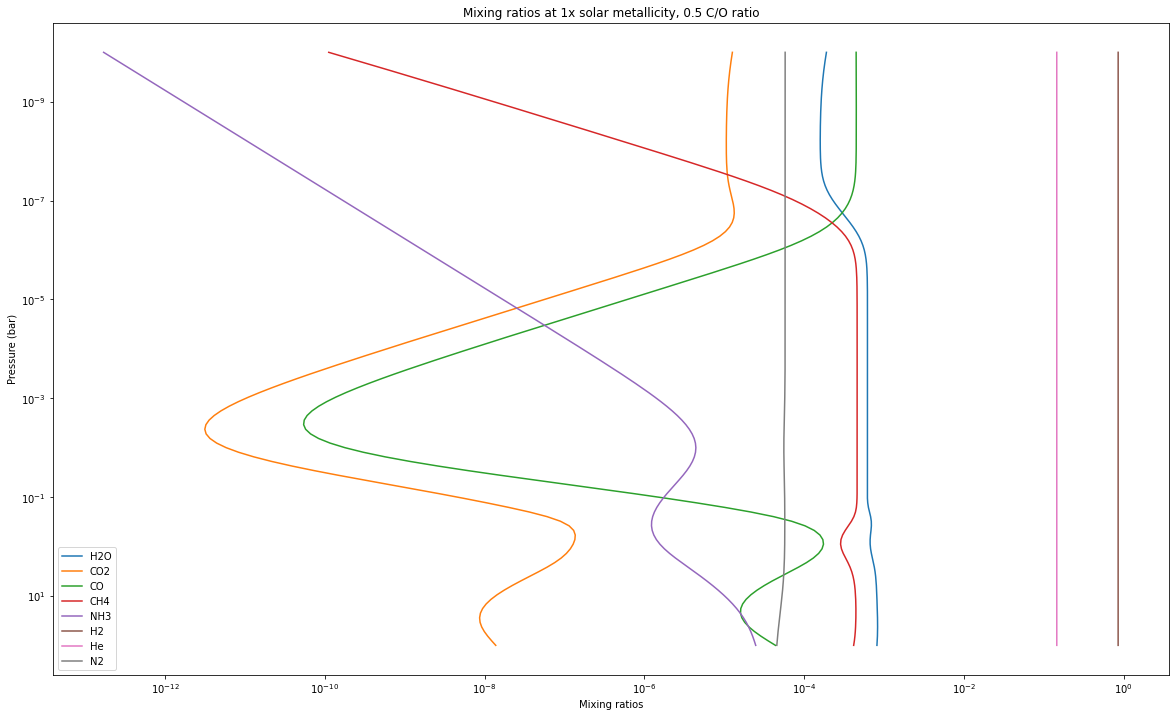

/Users/pearceo/opt/anaconda3/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



FastChem initialisation summary:
  number of species: 523    elements: 28    molecules: 495    chemical elements: 86

  Read line opacities of CO_all_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
  Read CIA opacities for N2-N2...
Done.

Normalised Transmission Spectrum


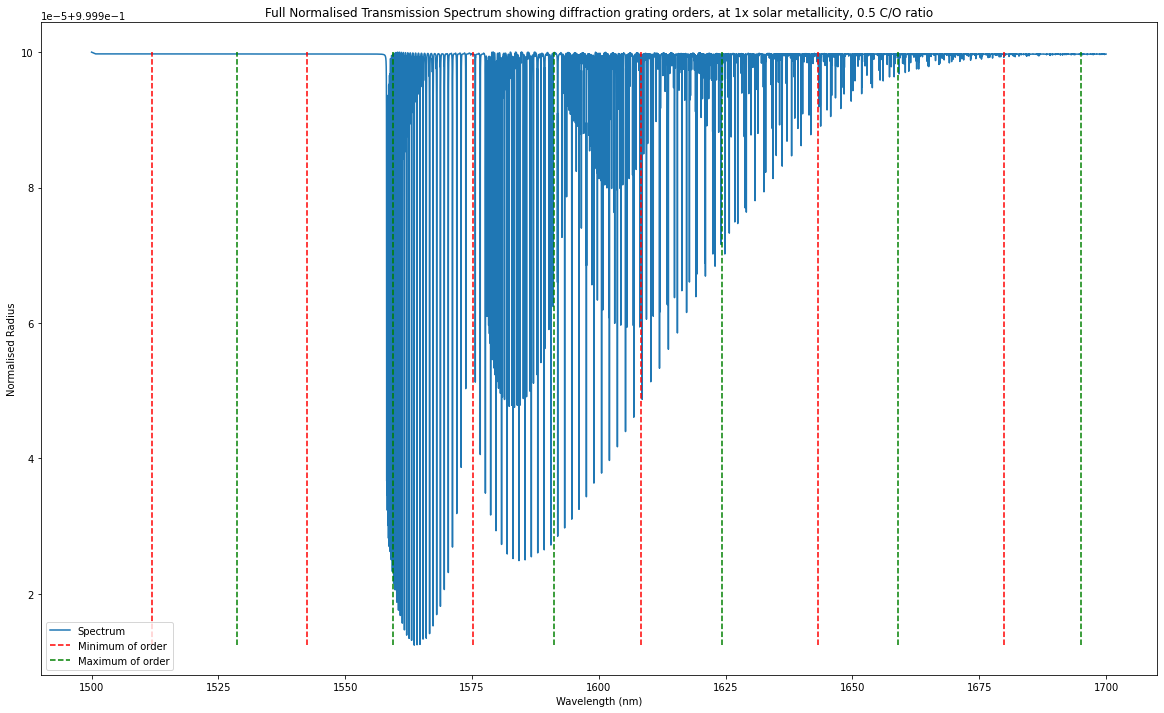

FastChem reports: convergence ok


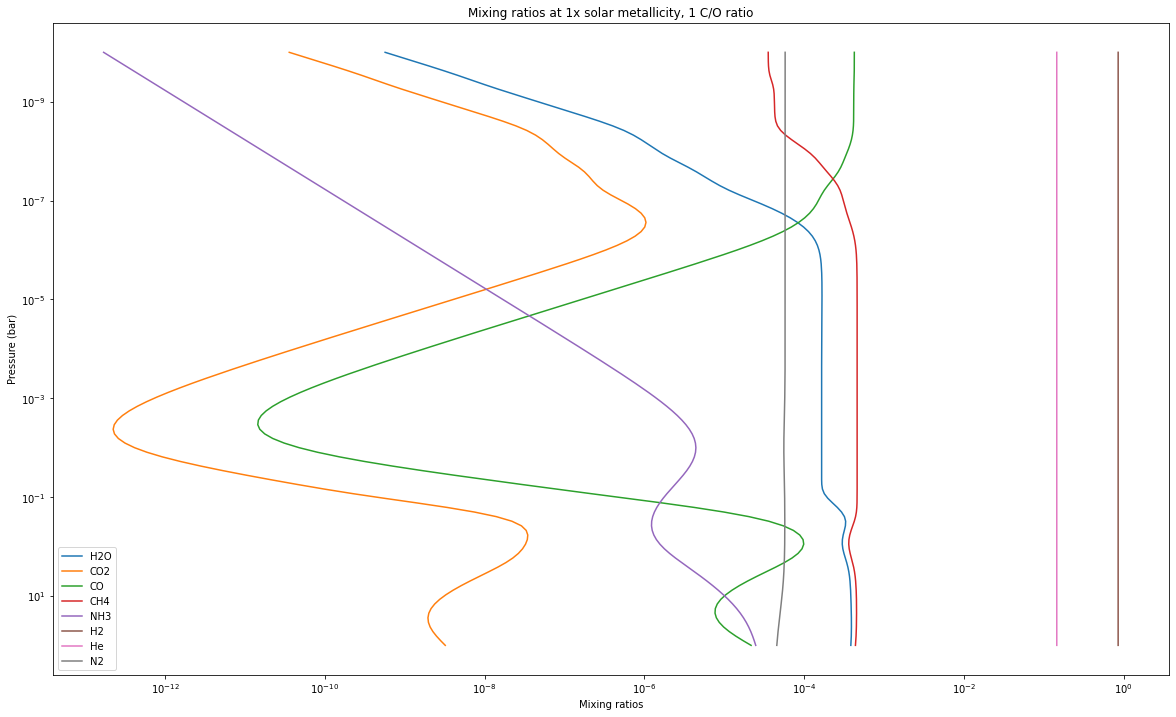

/Users/pearceo/opt/anaconda3/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



FastChem initialisation summary:
  number of species: 523    elements: 28    molecules: 495    chemical elements: 86

  Read line opacities of CO_all_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
  Read CIA opacities for N2-N2...
Done.

Normalised Transmission Spectrum


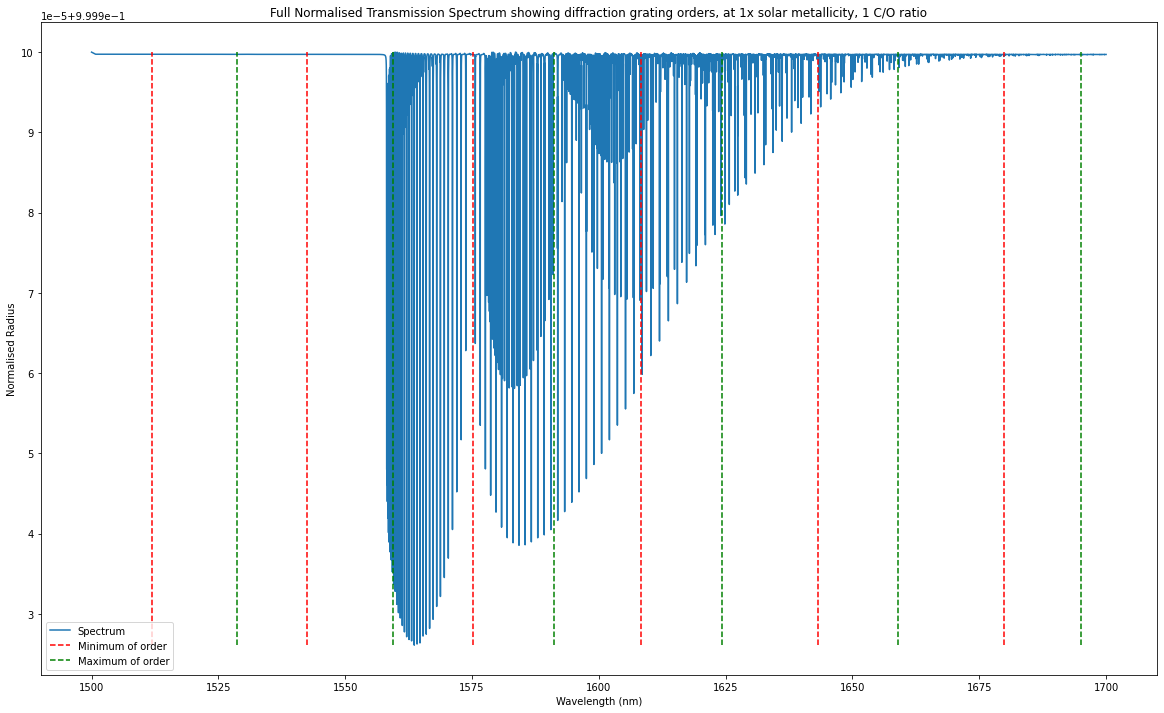

FastChem reports: convergence ok


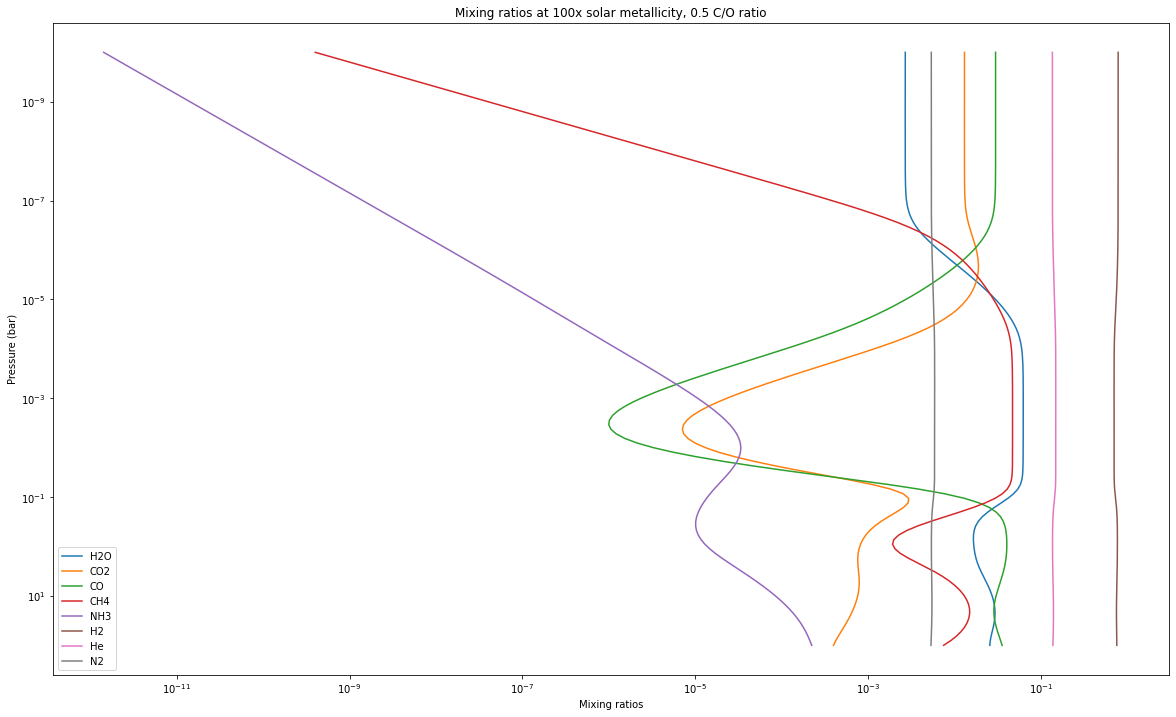

/Users/pearceo/opt/anaconda3/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



FastChem initialisation summary:
  number of species: 523    elements: 28    molecules: 495    chemical elements: 86

  Read line opacities of CO_all_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
  Read CIA opacities for N2-N2...
Done.

Normalised Transmission Spectrum


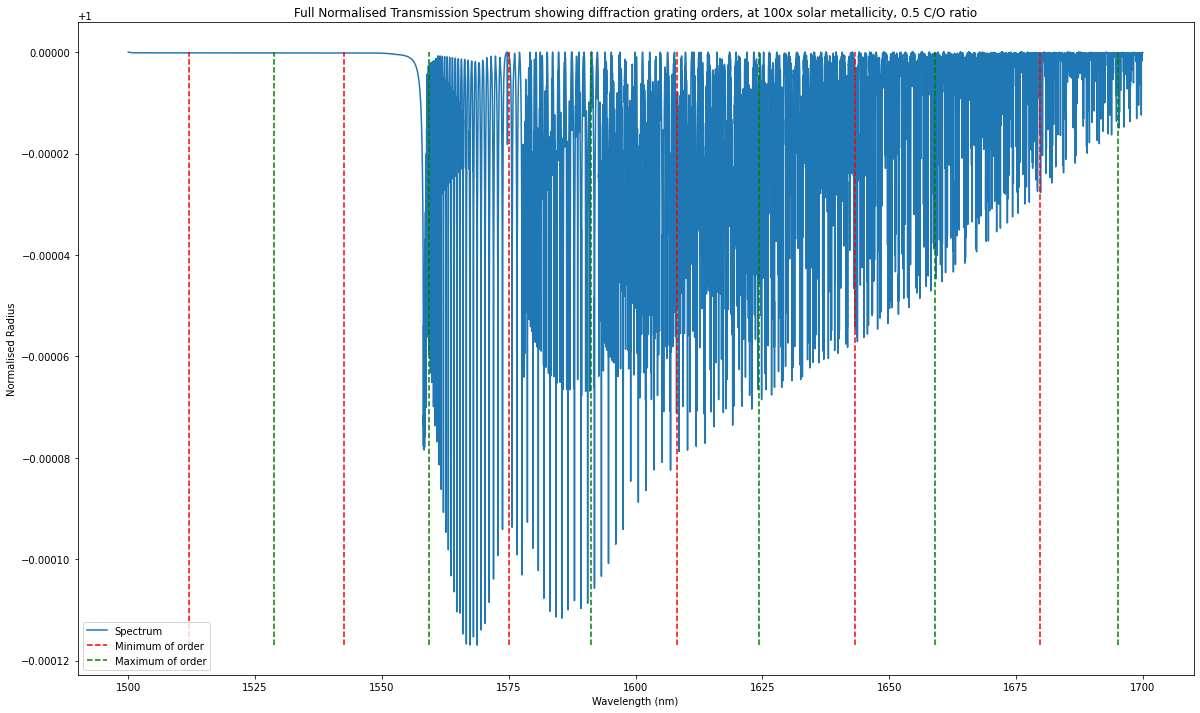

FastChem reports: convergence ok


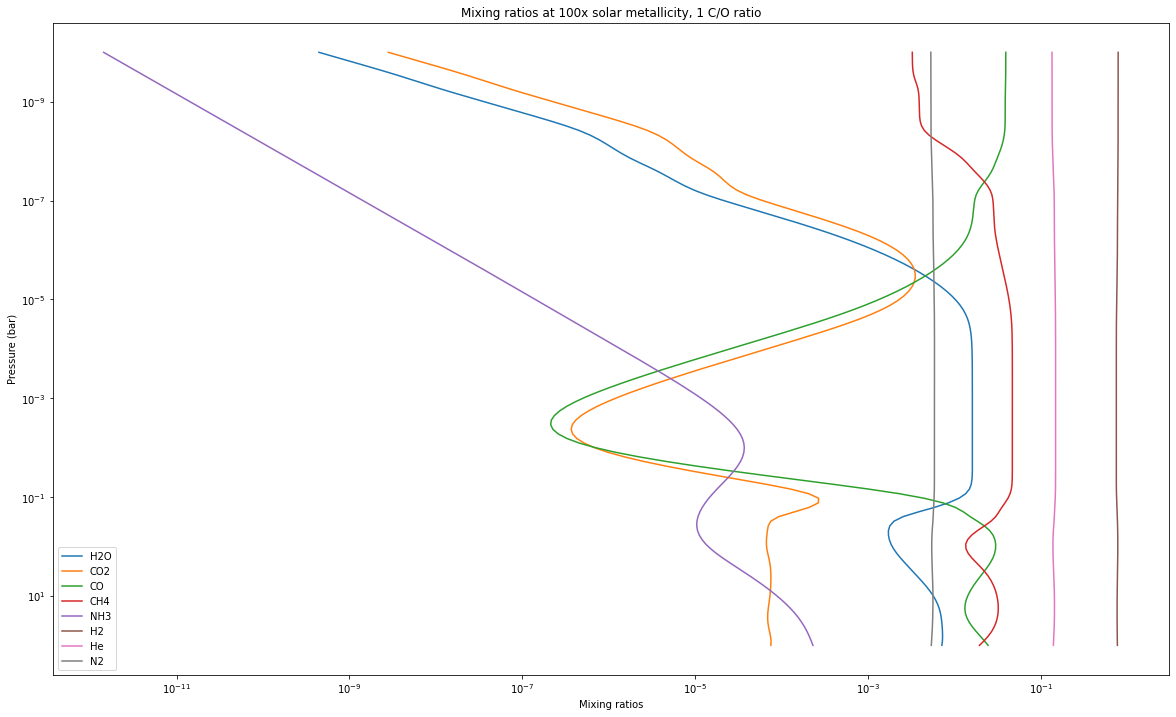

/Users/pearceo/opt/anaconda3/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



FastChem initialisation summary:
  number of species: 523    elements: 28    molecules: 495    chemical elements: 86

  Read line opacities of CO_all_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
  Read CIA opacities for N2-N2...
Done.

Normalised Transmission Spectrum


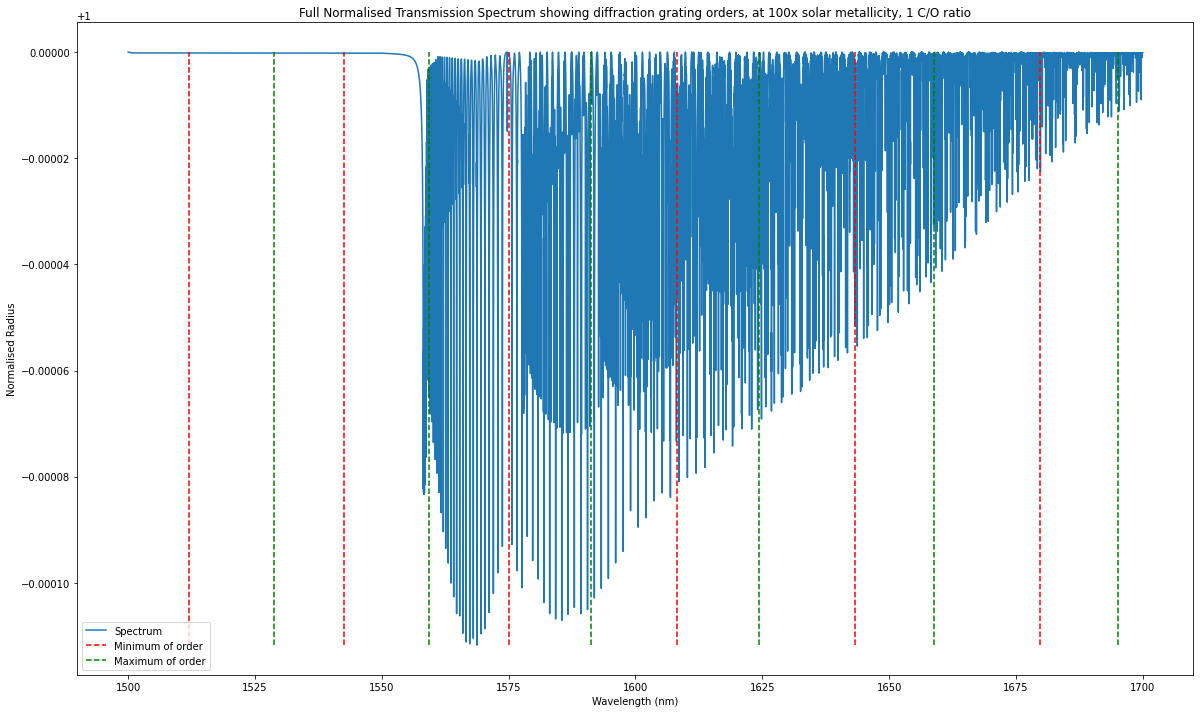

In [5]:
LS = ['CO_all_iso']
generate_spectra(LS,1500,1700)